In [26]:
from datasets import get_dataset

from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file
from lifelines import KaplanMeierFitter
import string

out_dir = Path("workspace")
fontsize = 14
plt.style.use("seaborn-whitegrid")
#plt.style.use("ggplot")

def map_models(model):
    return {
        "survival_gan": "SurvivalGAN", 
        "adsgan": "AdsGAN", 
        "ctgan": "CTGAN", 
        "tvae": "TVAE", 
        "privbayes": "PrivBayes", 
        "nflow": "nFlows"
    }[model]

def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = None,
    yaxis_label: str = None,
    show_title: bool = True,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(ax = ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors)

    if syn_label is None:
        syn_label = "Synthetic data"
        
    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if show_title:
        ax.set_xlabel(title, horizontalalignment="center")
    else:
        ax.set_xlabel("Days", horizontalalignment="center")
    
    if yaxis_label is None:
        yaxis_label = "Temporal fidelity(Kaplan-Meier)"
    ax.set_ylabel(yaxis_label)

def plot_tsne(
    ax,
    proj_real: pd.DataFrame,
    df_syn: pd.DataFrame,
) -> None:   
    tsne_syn = TSNE(n_components=2, random_state=0)
    proj_syn = pd.DataFrame(tsne_syn.fit_transform(df_syn))

    ax.scatter(x = proj_real[0], y = proj_real[1], s=3, alpha=0.8, label='Real data')
    ax.scatter(x = proj_syn[0], y = proj_syn[1], s=3, alpha=0.8, label='Synthetic data')
    ax.set_ylabel("Covariate diversity(t-SNE)", fontsize = fontsize)

def plot_2d(
    dataset: str,
    models: list,
    individual: bool = False,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    repeat_id: int = 0,
    save: bool = False,
    **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    df_hash = dataframe_hash(df)
    
    tsne = TSNE(n_components=2, random_state=0)
    proj_real = pd.DataFrame(tsne.fit_transform(df))
    
    fig, axs = plt.subplots(2, len(models), figsize = (4 * len(models), 6))
        
    for idx, model in enumerate(models):
        model_bkp = (
            out_dir
            / f"{df_hash}_{model}_{repeat_id}.bkp"
        )
        if model_bkp.exists():
            syn_df = load_from_file(model_bkp)
        else:
            print(model_bkp, "missing")
            continue


        plot_tsne(axs[0][idx], proj_real, syn_df)
        plot_km(axs[1][idx], map_models(model), df[duration_col], df[event_col], syn_df[duration_col], syn_df[event_col])
    
    fig.suptitle(f"Dataset: {dataset}", fontsize = 16)
    plt.tight_layout()

    if save:
        plt.savefig(f"diagrams/fidelity_grouped_{dataset}.pdf")
        plt.savefig(f"diagrams/fidelity_grouped_{dataset}.png")
    plt.show()
    
def plot_individual_km(
    dataset: str,
    models: list,
    individual: bool = False,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    repeat_id: int = 0,
    save: bool = False,
    **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    df_hash = dataframe_hash(df)
    
    for idx, model in enumerate(models):
        model_bkp = (
            out_dir
            / f"{df_hash}_{model}_{repeat_id}.bkp"
        )
        if model_bkp.exists():
            syn_df = load_from_file(model_bkp)
        else:
            print(model_bkp, "missing")
            continue

        plot_km(None, 
                map_models(model), 
                df[duration_col], 
                df[event_col], 
                syn_df[duration_col], 
                syn_df[event_col],
                syn_label = f"Synthetic model: {map_models(model)}",
                show_title = False,
                yaxis_label = "Event Probability"
               )

        if save:
            plt.savefig(f"diagrams/individual_kmplot_synth_gen_{dataset}_{model}.pdf")
        plt.show()
    


In [27]:
baseline_models = ["survival_gan", "adsgan", "ctgan", "tvae", "privbayes", "nflow"]

## AIDS

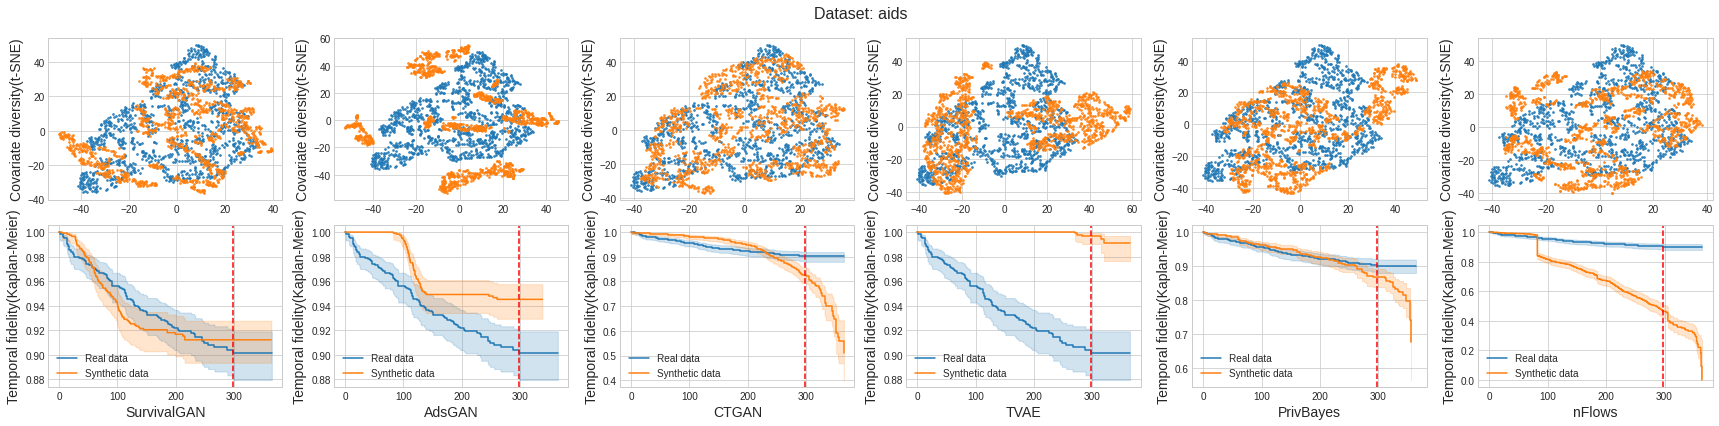

In [49]:
plot_2d(
        "aids", models=baseline_models, repeat_id = 1, save = True,
    )

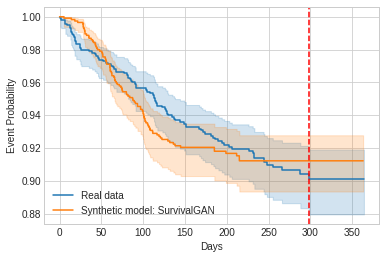

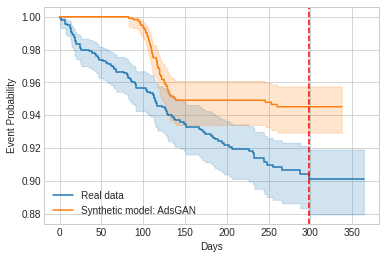

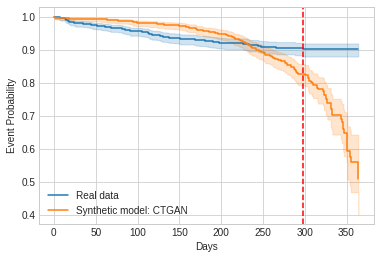

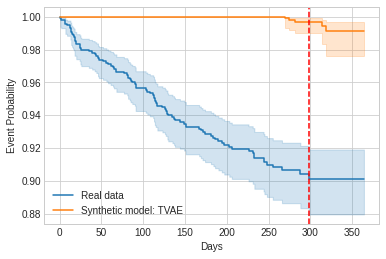

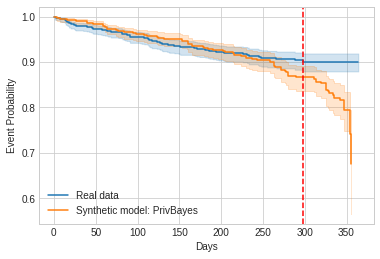

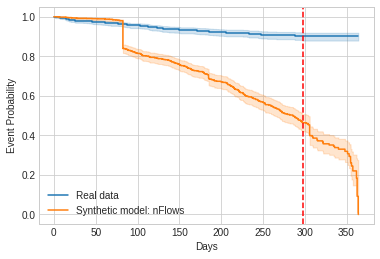

In [28]:
plot_individual_km(
        "aids", models=baseline_models, repeat_id = 1, save = True,
    )

## Metabric

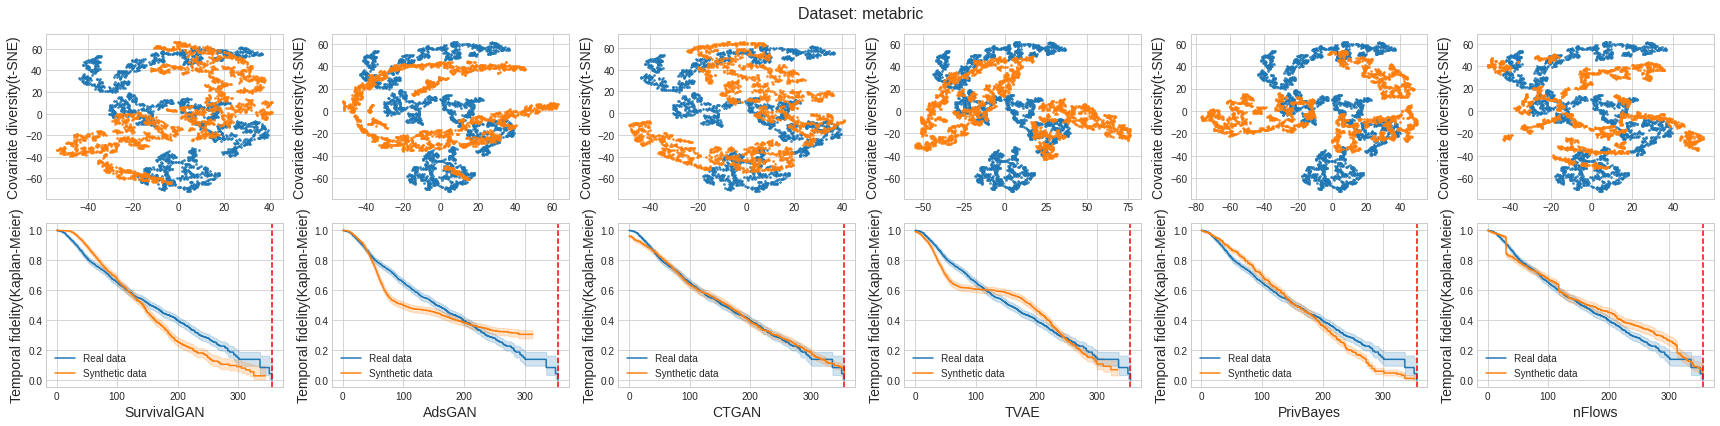

In [50]:
plot_2d(
        "metabric", models=baseline_models, repeat_id = 1, save = True
    )

## CUTRACT

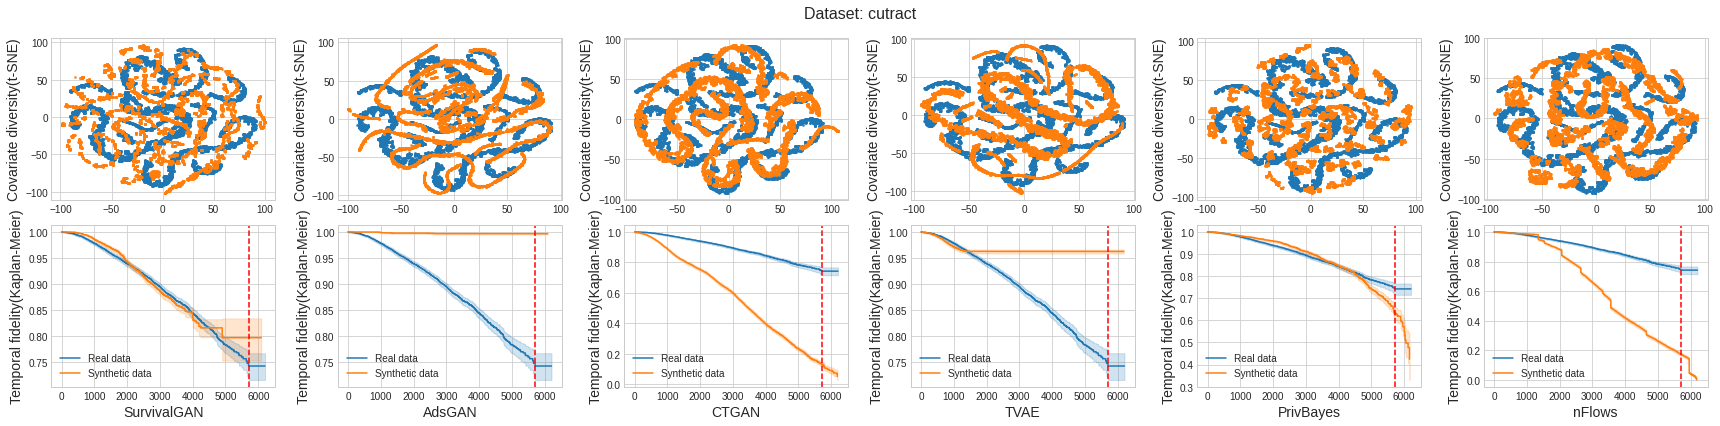

In [51]:
plot_2d(
        "cutract", models=baseline_models, repeat_id = 0, save = True
    )

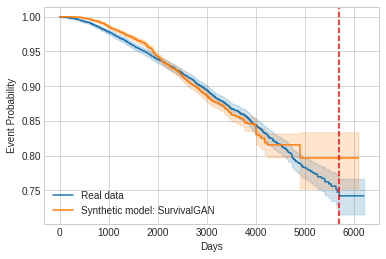

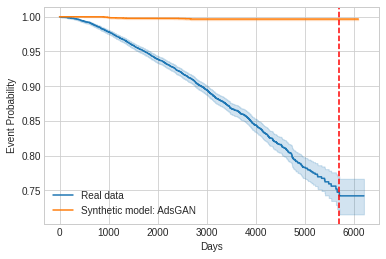

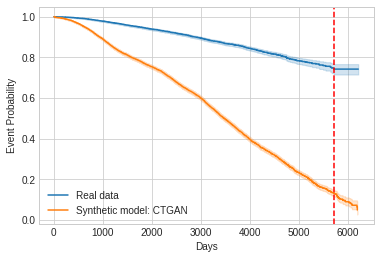

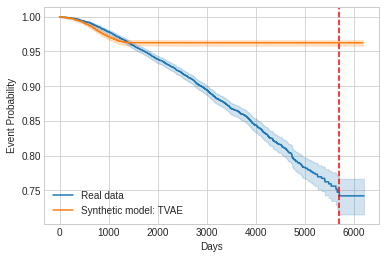

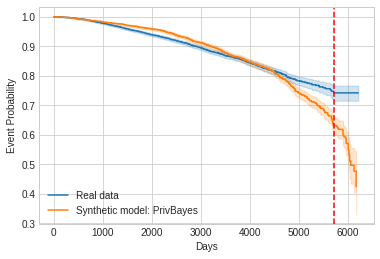

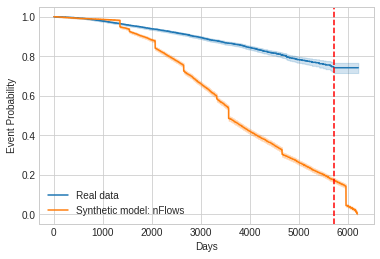

In [29]:
plot_individual_km(
        "cutract", models=baseline_models, repeat_id = 0, save = True,
    )

## MAGGIC

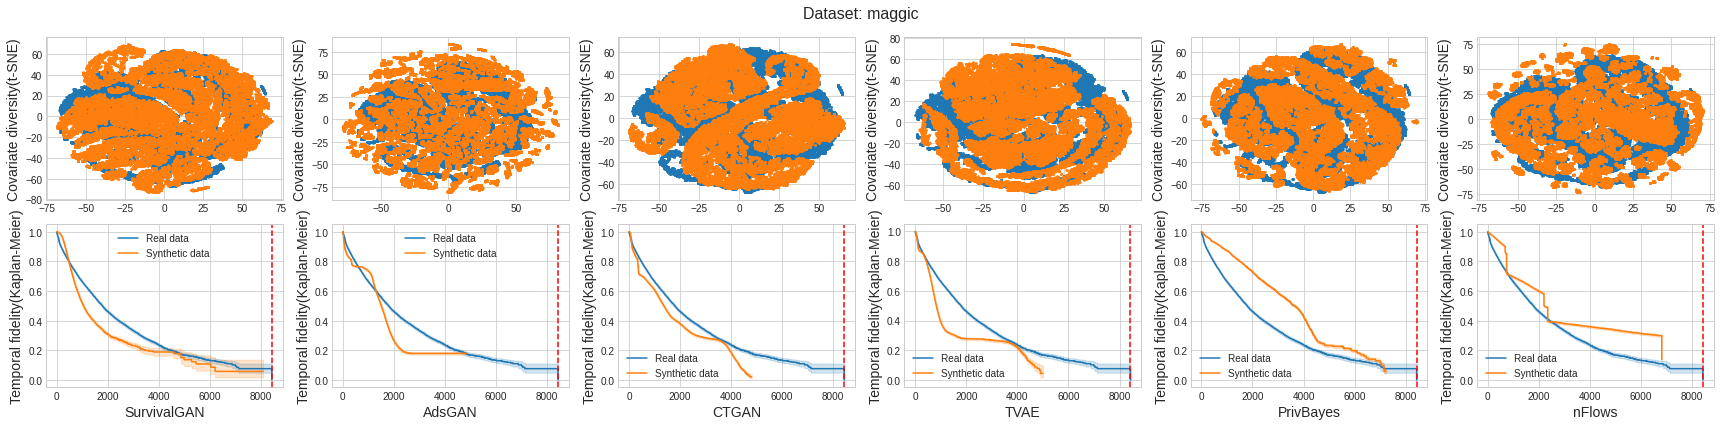

In [54]:
plot_2d(
        "maggic", models=baseline_models, repeat_id = 1, save = True
    )

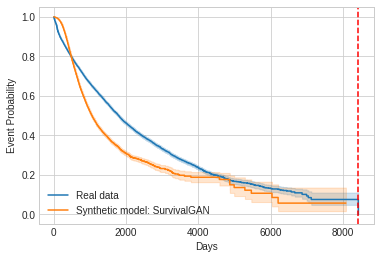

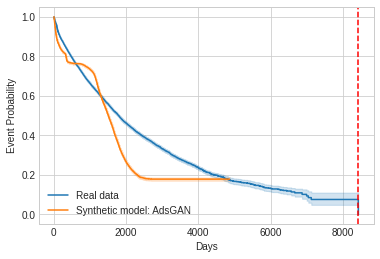

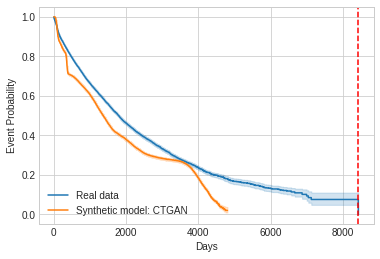

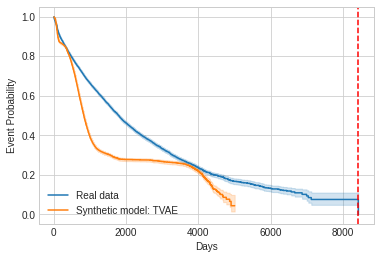

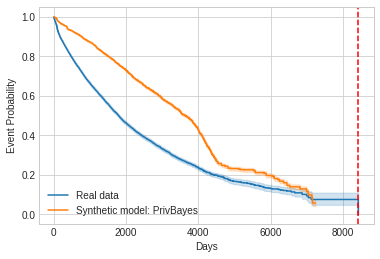

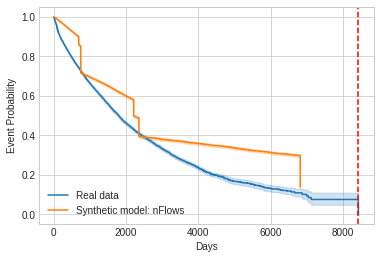

In [30]:
plot_individual_km(
        "maggic", models=baseline_models, repeat_id = 1, save = True,
    )

## SEER

In [ ]:
plot_dataset_perf_baselines(
    "seer", models=baseline_models,
)